### FitJourney Concept

1. Meal Selection: Users start by selecting a meal (breakfast, lunch, or dinner) based on their current schedule.
2. Menu Search and Nutrition Calculation: Users can search for a desired menu item from the recipe dataset. The app then calculates the nutritional content (calories, fat, protein, etc.) of the selected menu.
3. Initial Menu Suggestions: For the first meal of the day, the app suggests around 10 menu options for the remaining meals (e.g., if the user selects breakfast, the app suggests 10 options for lunch and 10 options for dinner).
4. Dynamic Suggestions: As the user progresses through the day and selects meals, the app dynamically updates its suggestions for the remaining meals, taking into account the user's previous choices and nutritional intake.
5. Nutrition Tracking: The app tracks the user's cumulative nutritional intake throughout the day.

### Data Source

The data used in this project is sourced from Kaggle and consists of recipes and reviews. The dataset provides a wide variety of food items along with their nutritional information, which is essential for generating accurate and relevant recommendations. The dataset can be accessed from https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews/data.


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d irkaal/foodcom-recipes-and-reviews

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/foodcom-recipes-and-reviews.zip', 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [ ]:
#1 Code Cell
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import os  # Operating system interactions

import matplotlib.pyplot as plt # Plotting library
%matplotlib inline

import seaborn as sns  # Statistical data visualization

from sklearn.preprocessing import MinMaxScaler  # Scaling features to a range
from sklearn.model_selection import train_test_split  # Splitting data into training and test sets
from sklearn.metrics.pairwise import cosine_similarity  # Calculating cosine similarity between vectors

import tensorflow as tf  # TensorFlow library for machine learning
from tensorflow.keras.models import Sequential  # Sequential model from Keras
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout  # Layers for the neural network
from tensorflow.keras.optimizers import Adam  # Optimizer for training the model

In [ ]:
#2 Code Cell
# Load the dataset from the specified CSV file
# data = pd.read_csv('/kaggle/input/foodcom-recipes-and-reviews/recipes.csv')
data = pd.read_csv('data/recipes.csv')

# Display the first few rows of the dataset to understand its structure
data.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [ ]:
#3 Code Cell
# Duplicate the original dataset to memory during session
df = data.copy()

# Display information about the dataset, including column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

In [ ]:
#4 Code Cell
# Select and reorder columns in the dataset for further analysis
selected_columns = ['RecipeId', 'Calories', 'FatContent', 'SaturatedFatContent',
                     'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
                     'FiberContent', 'SugarContent', 'ProteinContent']

# Apply the selected columns to the DataFrame
df = df[selected_columns]

# Display the first few rows of the updated DataFrame
df.head()

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
0,38,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2
1,39,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4
2,40,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3
3,41,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3
4,42,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3


In [ ]:
#5 Code Cell
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   RecipeId             522517 non-null  int64  
 1   Calories             522517 non-null  float64
 2   FatContent           522517 non-null  float64
 3   SaturatedFatContent  522517 non-null  float64
 4   CholesterolContent   522517 non-null  float64
 5   SodiumContent        522517 non-null  float64
 6   CarbohydrateContent  522517 non-null  float64
 7   FiberContent         522517 non-null  float64
 8   SugarContent         522517 non-null  float64
 9   ProteinContent       522517 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 39.9 MB


In [ ]:
#6 Code Cell
df.isnull().sum()

,0
RecipeId,0
Calories,0
FatContent,0
SaturatedFatContent,0
CholesterolContent,0
SodiumContent,0
CarbohydrateContent,0
FiberContent,0
SugarContent,0
ProteinContent,0


---


calls the `describe()` method on the DataFrame `df`.

This method generates descriptive statistics that summarize the central tendency, dispersion, and shape of the dataset's distribution, excluding any `NaN` values. The output of this method varies depending on the data types of the columns in the DataFrame.

For numeric data, `df.describe()` returns statistics such as:

- `count`: The number of non-null values.
- `mean`: The average of the values.
- `std`: The standard deviation of the values.
- `min`: The minimum value.
- `25%`: The 25th percentile (first quartile).
- `50%`: The 50th percentile (median).
- `75%`: The 75th percentile (third quartile).
- `max`: The maximum value.

For object data (e.g., strings or timestamps), the method returns:

- `count`: The number of non-null values.
- `unique`: The number of unique values.
- `top`: The most frequent value.
- `freq`: The frequency of the most frequent value.

The `describe()` method can be customized using parameters such as `percentiles`, `include`, and `exclude`. The `percentiles` parameter allows you to specify which percentiles to include in the output. The `include` parameter lets you specify which data types to include in the summary, while the `exclude` parameter allows you to omit certain data types from the summary.

In summary, `df.describe()` is a powerful tool for quickly obtaining a comprehensive overview of the dataset, making it easier to identify patterns, trends, and potential issues in the data. It provides a convenient way to understand the distribution and spread of both numeric and object data within the DataFrame.


In [ ]:
#7 Code Cell
df.describe()

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
count,522517.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000
mean,271821.436970,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510
std,155495.878422,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837
min,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,137206.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000
50%,271758.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000
75%,406145.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000
max,541383.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000


In [ ]:
#8 Code Cell
# Display summary statistics of the DataFrame, including specified percentiles
# Transpose the result for better readability
summary_statistics = df.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T

# Show the summary statistics
summary_statistics


,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
RecipeId,522517.0,271821.436970,155495.878422,38.0,29659.8,56405.6,137206.0,271758.0,406145.0,487592.4,514600.2,541383.0
Calories,522517.0,484.438580,1397.116649,0.0,55.0,90.1,174.2,317.1,529.1,862.8,1305.8,612854.6
FatContent,522517.0,24.614922,111.485798,0.0,0.2,1.2,5.6,13.8,27.4,49.4,75.6,64368.1
SaturatedFatContent,522517.0,9.559457,46.622621,0.0,0.0,0.2,1.5,4.7,10.8,20.3,30.2,26740.6
CholesterolContent,522517.0,86.487003,301.987009,0.0,0.0,0.0,3.8,42.6,107.9,202.3,291.5,130456.4
SodiumContent,522517.0,767.263878,4203.620531,0.0,7.5,28.8,123.3,353.3,792.2,1477.2,2217.1,1246921.1
CarbohydrateContent,522517.0,49.089092,180.822062,0.0,2.4,5.0,12.8,28.2,51.1,86.8,136.8,108294.6
FiberContent,522517.0,3.843242,8.603163,0.0,0.0,0.2,0.8,2.2,4.6,8.6,12.7,3012.0
SugarContent,522517.0,21.878254,142.620191,0.0,0.2,0.8,2.5,6.4,17.9,41.8,71.1,90682.3
ProteinContent,522517.0,17.469510,40.128837,0.0,0.5,1.2,3.5,9.1,25.0,41.3,54.1,18396.2


In [ ]:
#9 Code Cell
# Define the columns to filter based on the 95th percentile
filter_columns = ['Calories', 'FatContent', 'SaturatedFatContent',
                   'CholesterolContent', 'SodiumContent',
                   'CarbohydrateContent', 'FiberContent',
                   'SugarContent', 'ProteinContent']

# Compute the 95th percentile values for each specified column
percentile_95_thresholds = df[filter_columns].quantile(0.95)

# Display the 95th percentile thresholds for each column
percentile_95_thresholds

,0.95
Calories,1305.8
FatContent,75.6
SaturatedFatContent,30.2
CholesterolContent,291.5
SodiumContent,2217.1
CarbohydrateContent,136.8
FiberContent,12.7
SugarContent,71.1
ProteinContent,54.1


In [ ]:
#10 Code Cell
# Apply filtering to the DataFrame based on the 95th percentile values
filtered_df = df[(df[filter_columns] <= percentile_95_thresholds).all(axis=1)]

# Print the filtered DataFrame
print(filtered_df)

        RecipeId  Calories  FatContent  SaturatedFatContent  \
0             38     170.9         2.5                  1.3   
4             42     103.6         0.4                  0.1   
5             43     437.9        19.3                 10.9   
7             45     228.0         7.1                  1.7   
8             46       4.3         0.0                  0.0   
...          ...       ...         ...                  ...   
522508    541375     422.3        28.6                 12.6   
522509    541376      84.3         2.1                  1.2   
522510    541377     358.9        19.8                 10.5   
522512    541379     316.6        12.5                  7.6   
522515    541382      16.1         0.6                  0.1   

        CholesterolContent  SodiumContent  CarbohydrateContent  FiberContent  \
0                      8.0           29.8                 37.1           3.6   
4                      0.0          959.3                 25.1           4.8   
5  

In [ ]:
#11 Code Cell
df.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
RecipeId,522517.0,271821.436970,155495.878422,38.0,29659.8,56405.6,137206.0,271758.0,406145.0,487592.4,514600.2,541383.0
Calories,522517.0,484.438580,1397.116649,0.0,55.0,90.1,174.2,317.1,529.1,862.8,1305.8,612854.6
FatContent,522517.0,24.614922,111.485798,0.0,0.2,1.2,5.6,13.8,27.4,49.4,75.6,64368.1
SaturatedFatContent,522517.0,9.559457,46.622621,0.0,0.0,0.2,1.5,4.7,10.8,20.3,30.2,26740.6
CholesterolContent,522517.0,86.487003,301.987009,0.0,0.0,0.0,3.8,42.6,107.9,202.3,291.5,130456.4
SodiumContent,522517.0,767.263878,4203.620531,0.0,7.5,28.8,123.3,353.3,792.2,1477.2,2217.1,1246921.1
CarbohydrateContent,522517.0,49.089092,180.822062,0.0,2.4,5.0,12.8,28.2,51.1,86.8,136.8,108294.6
FiberContent,522517.0,3.843242,8.603163,0.0,0.0,0.2,0.8,2.2,4.6,8.6,12.7,3012.0
SugarContent,522517.0,21.878254,142.620191,0.0,0.2,0.8,2.5,6.4,17.9,41.8,71.1,90682.3
ProteinContent,522517.0,17.469510,40.128837,0.0,0.5,1.2,3.5,9.1,25.0,41.3,54.1,18396.2


In [ ]:
#12 Code Cell
sample_size = 6000
if sample_size > len(df):
    sample_size = len(df)  # If desired sample size is larger, use the full DataFrame
    print("Warning: Sample size reduced to DataFrame size to avoid error.")

df = df.sample(sample_size)  # Sample with the adjusted size
df.head()

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
451476,468161,632.0,41.6,5.7,0.0,84.1,66.7,23.1,31.2,10.8
200767,209526,180.2,12.4,6.4,42.4,782.5,5.7,0.5,3.4,11.2
479537,497202,356.7,16.1,6.4,55.6,1158.8,29.4,3.4,7.9,25.2
245037,255031,506.8,28.1,10.4,151.3,447.1,18.4,4.8,2.2,40.3
42959,46877,110.8,7.8,4.9,20.3,67.9,9.7,0.3,3.6,0.9


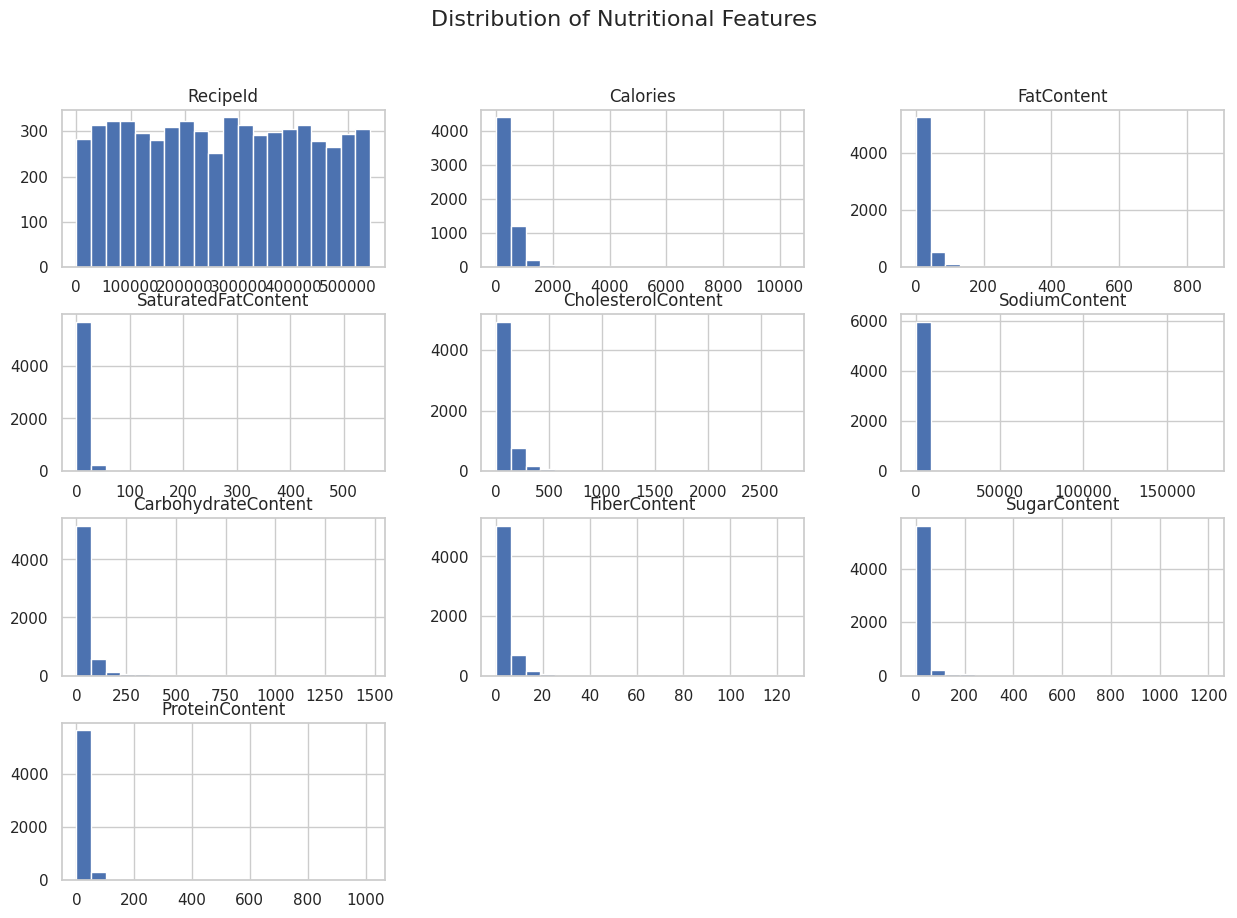

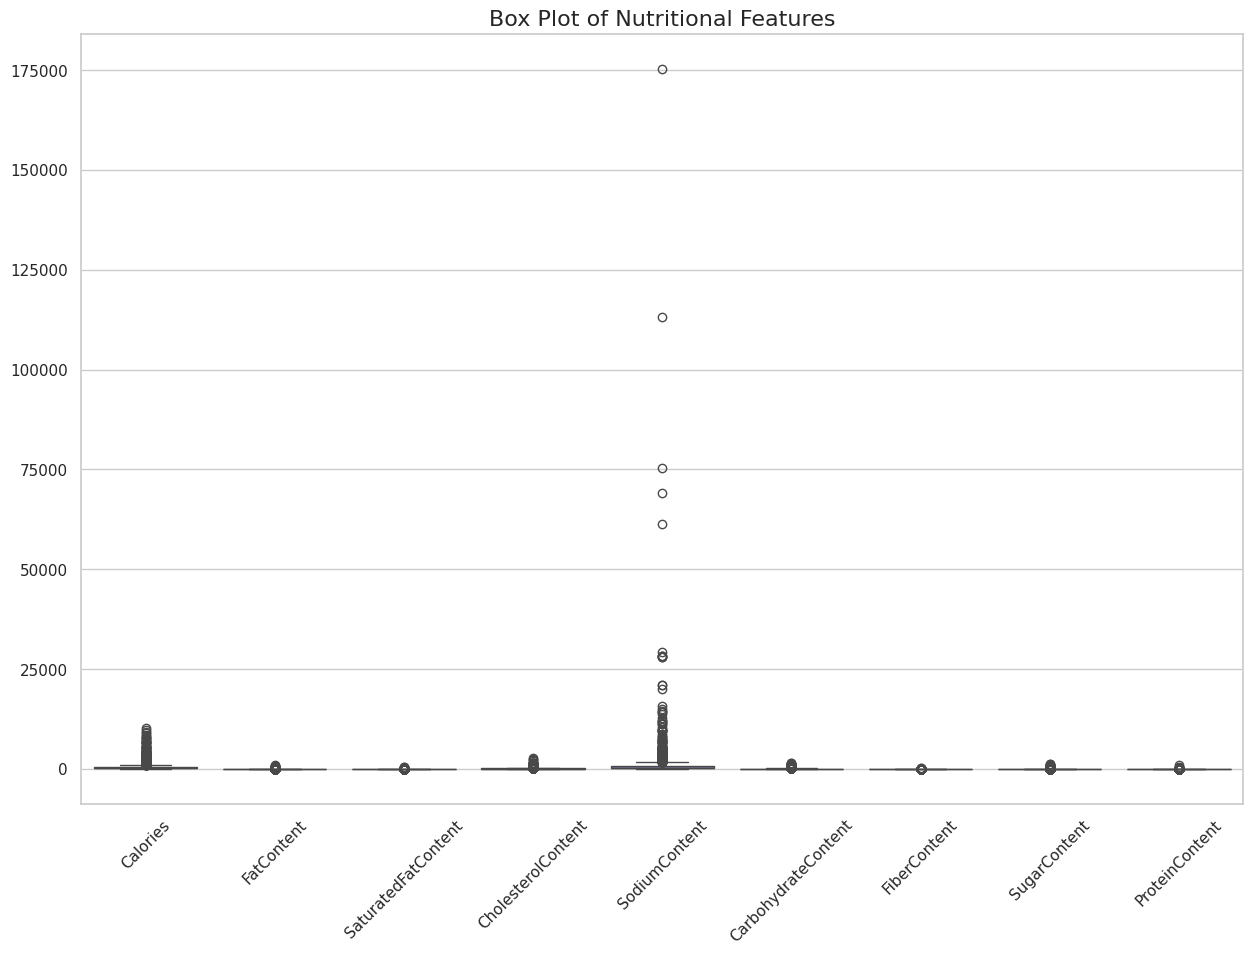

In [ ]:
#13 Code Cell
# Set the aesthetic style of the plots to "whitegrid" for better readability
sns.set(style="whitegrid")

# Create histograms for all numerical columns to visualize the distribution of each feature
# The histograms will have 20 bins and a figure size of 15x10 inches
df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Nutritional Features', fontsize=16)  # Set the title of the histograms
plt.show()  # Display the histograms

# Create box plots to visualize the distribution and check for outliers in the data
# Drop the 'RecipeId' column as it is not a numerical feature and not needed for this plot
plt.figure(figsize=(15, 10))
sns.boxplot(data=df.drop(columns=['RecipeId']))  # Create the box plot
plt.title('Box Plot of Nutritional Features', fontsize=16)  # Set the title of the box plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()  # Display the box plot

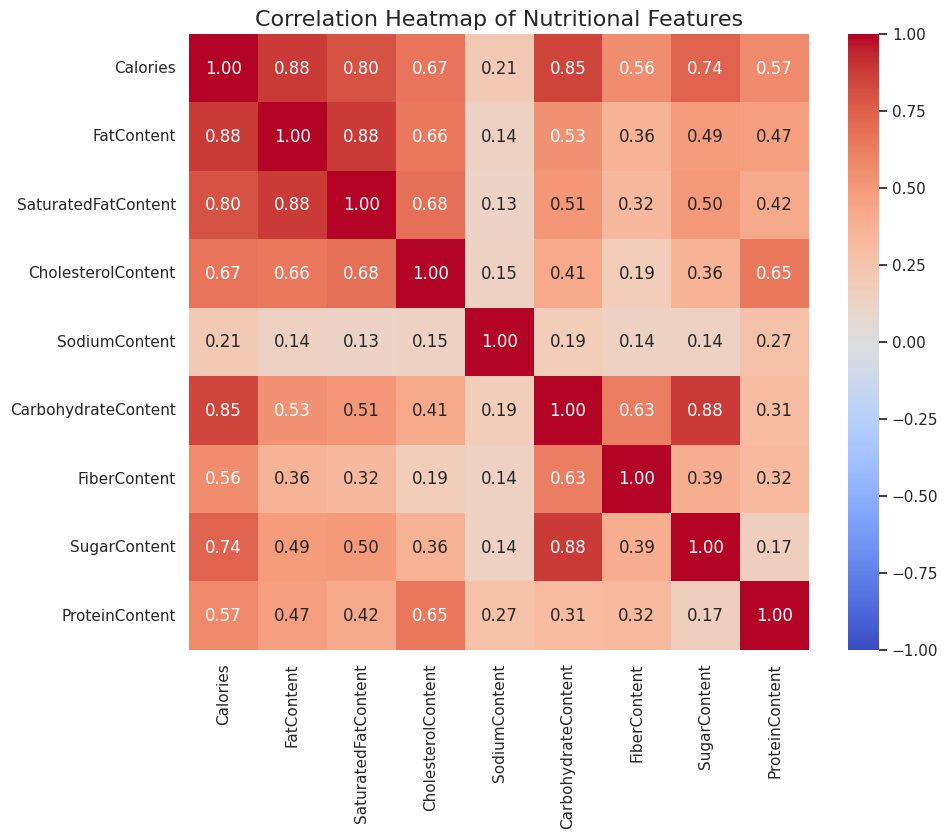

In [ ]:
#14 Code Cell
# Compute the correlation matrix for the nutritional features
# The 'RecipeId' column is dropped as it's not a numerical feature and does not contribute to the correlation calculation
corr = df.drop(columns=['RecipeId']).corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))  # Set the figure size for the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)  # Create the heatmap
# `annot=True` adds the correlation coefficients on the heatmap
# `cmap='coolwarm'` sets the color map to show the correlation values with a gradient from cool to warm
# `fmt='.2f'` formats the correlation values to two decimal places
# `vmin` and `vmax` set the color scale range for better visualization of correlations
plt.title('Correlation Heatmap of Nutritional Features', fontsize=16)  # Set the title of the heatmap
plt.show()  # Display the heatmap

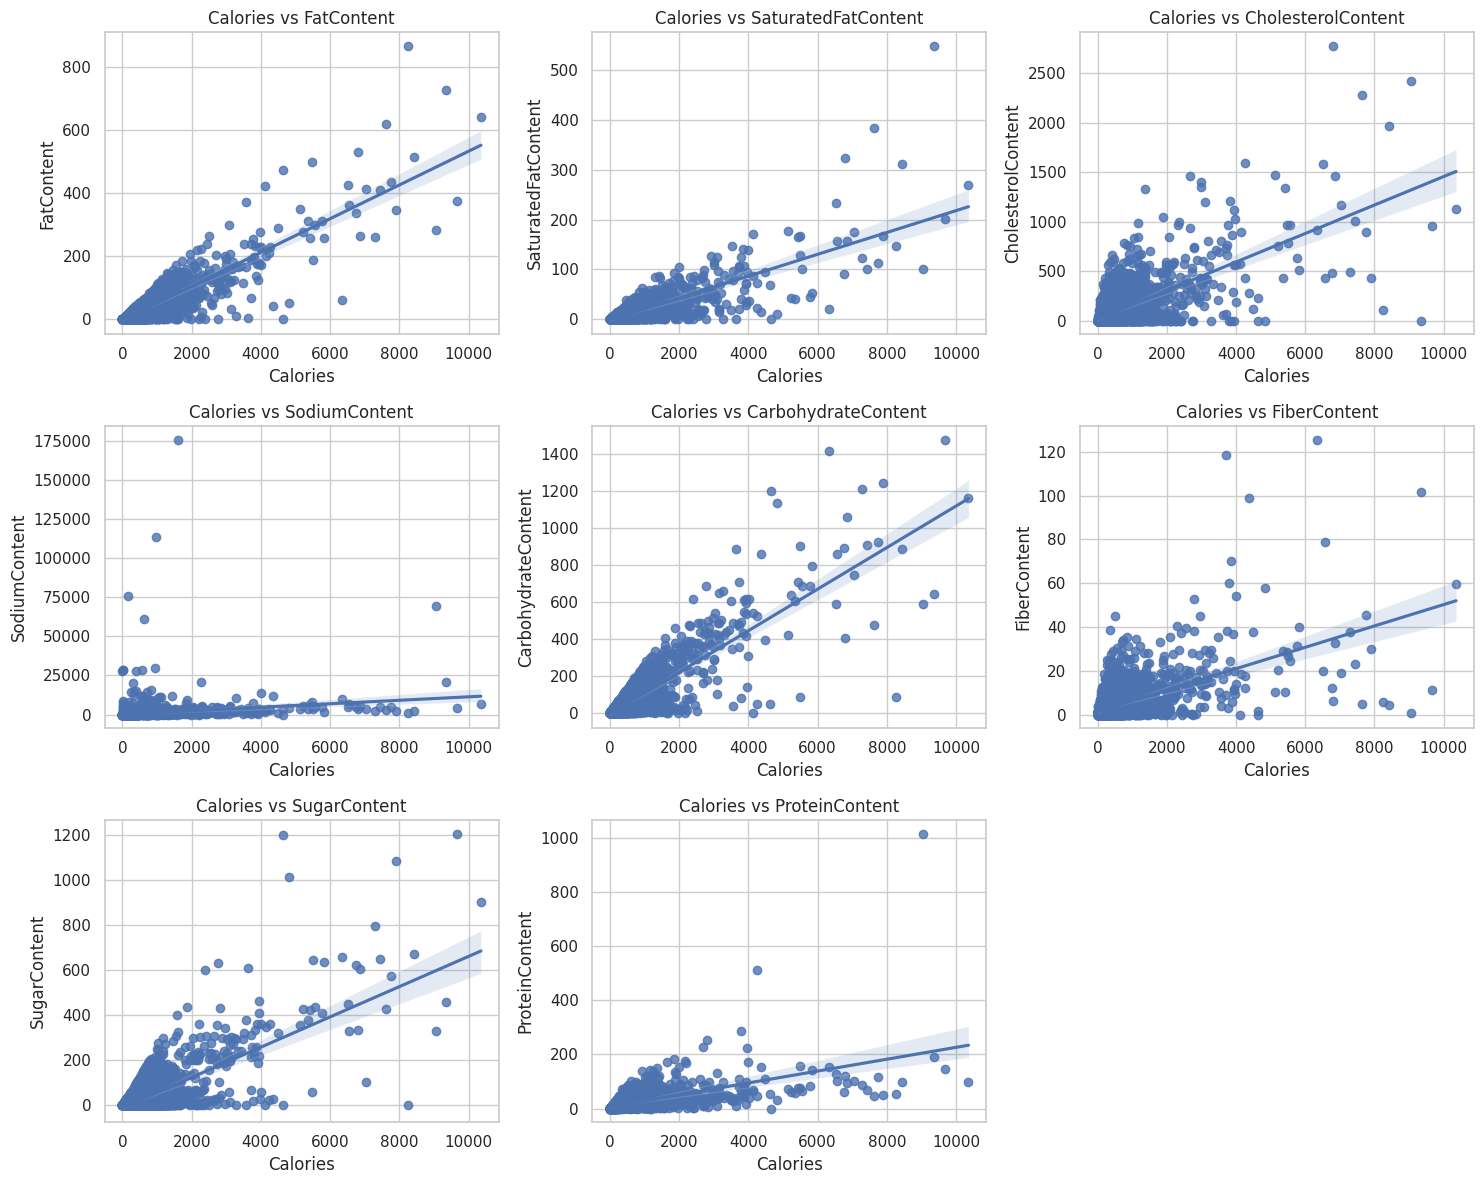

In [ ]:
#15 Code Cell
# List of features to compare against 'Calories'
features_to_compare = ['FatContent', 'SaturatedFatContent', 'CholesterolContent',
                       'SodiumContent', 'CarbohydrateContent', 'FiberContent',
                       'SugarContent', 'ProteinContent']

# Set up the figure with a specified size
plt.figure(figsize=(15, 12))

# Loop through each feature and create a scatter plot
for i, feature in enumerate(features_to_compare, 1):
    # Create a subplot for each feature
    plt.subplot(3, 3, i)
    # Generate a scatter plot of 'Calories' vs. the current feature
    # sns.scatterplot(x='Calories', y=feature, data=df)
    sns.regplot(x='Calories', y=feature, data=df)
    # Set the title for the scatter plot
    plt.title(f'Calories vs {feature}')

# Adjust subplot parameters for a tight layout
plt.tight_layout()

# Display all the scatter plots
plt.show()

In [ ]:
#16 Code Cell
# Drop the 'RecipeId' column from the DataFrame and assign the result to X
X = df.drop(columns=['RecipeId'])

# Assign the 'RecipeId' column to y
y = df['RecipeId']

In [ ]:
#17 Code Cell
X.head()

,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
451476,632.0,41.6,5.7,0.0,84.1,66.7,23.1,31.2,10.8
200767,180.2,12.4,6.4,42.4,782.5,5.7,0.5,3.4,11.2
479537,356.7,16.1,6.4,55.6,1158.8,29.4,3.4,7.9,25.2
245037,506.8,28.1,10.4,151.3,447.1,18.4,4.8,2.2,40.3
42959,110.8,7.8,4.9,20.3,67.9,9.7,0.3,3.6,0.9


In [ ]:
#18 Code Cell
y.head()

,RecipeId
451476,468161
200767,209526
479537,497202
245037,255031
42959,46877


In [ ]:
#19 Code Cell
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to X and transform it
X_scaled = scaler.fit_transform(X)

In [ ]:
#20 Code Cell
# Split data into training, development, and test sets
X_train_scaled, X_temp_scaled, y_train, y_temp = train_test_split(
    X_scaled, y, train_size=0.8, random_state=42
)
X_eval_scaled, X_test_scaled, y_eval, y_test = train_test_split(
    X_temp_scaled, y_temp, train_size=0.5, random_state=42
)

# Display the shapes of the resulting sets
print("Training set shape:", X_train_scaled.shape)
print("Development set shape:", X_eval_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Training set shape: (4800, 9)
Development set shape: (600, 9)
Test set shape: (600, 9)


In [ ]:
#21 Code Cell
# Neural Network Model Architecture
from tensorflow.keras import regularizers  # Import regularizers
num_features = X_train_scaled.shape[1]  # Number of features in the input data

# Define the autoencoder model
model = Sequential([
    # Encoder
    Dense(256, input_shape=(num_features,), kernel_regularizer=regularizers.l2(0.01)), # Input layer with 256 neurons
    LeakyReLU(),  # Activation function with a small slope for negative inputs
    Dropout(0.2),  # Dropout layer with 20% dropout rate to prevent overfitting
    Dense(128, kernel_regularizer=regularizers.l2(0.01)),  # Hidden layer with 128 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer
    Dense(64, kernel_regularizer=regularizers.l2(0.01)),  # Hidden layer with 64 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer

    # Bottleneck
    Dense(32),  # Bottleneck layer with 32 neurons, this is the compressed representation of the input data
    # The bottleneck layer reduces the dimensionality of the input data, capturing essential features

    # Decoder
    Dense(64, kernel_regularizer=regularizers.l2(0.01)),  # Hidden layer in the decoder with 64 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer
    Dense(128, kernel_regularizer=regularizers.l2(0.01)),  # Hidden layer with 128 neurons
    LeakyReLU(),  # Activation function
    Dropout(0.2),  # Dropout layer
    Dense(256, kernel_regularizer=regularizers.l2(0.01)),  # Hidden layer with 256 neurons
    LeakyReLU(),  # Activation function

    # Output layer
    Dense(num_features, activation='linear')  # Output layer with the same number of neurons as features, linear activation
    # The linear activation function in the output layer allows the network to reconstruct the input data directly
])

# Summary of the model to check the architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 256)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,561 (357.66 KB)

 Trainable params: 91,561 (357.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#22 Code Cell
# Compile the model using a more concise syntax using Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse', # Mean Squared Error for regression
              metrics=['mae']) # Mean Absolute Error for regression evaluation

In [ ]:
#23 Code Cell
# Fit the model with scaled training data as both input and target
training_history = model.fit(
    X_train_scaled, X_train_scaled,  # Input and target are the same for an autoencoder
    epochs=20,  # Number of epochs for training
    batch_size=32,  # Batch size for training
    validation_data=(X_eval_scaled, X_eval_scaled),  # Validation data to monitor performance
    verbose=1  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
)

# Extract validation loss from the training history
validation_loss = training_history.history['val_loss']

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 5.3115 - mae: 0.0206 - val_loss: 4.1783 - val_mae: 0.0210
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8667 - mae: 0.0201 - val_loss: 3.0323 - val_mae: 0.0213
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8018 - mae: 0.0194 - val_loss: 2.1870 - val_mae: 0.0214
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.0173 - mae: 0.0205 - val_loss: 1.5657 - val_mae: 0.0218
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4413 - mae: 0.0205 - val_loss: 1.1121 - val_mae: 0.0212
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0212 - mae: 0.0198 - val_loss: 0.7837 - val_mae: 0.0216
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7183 - mae: 0.0199 - val_loss: 0.5483 - val_mae: 0.0225
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5013 - mae: 0.0199 - val_loss: 0.3812 - val_mae: 0.0229
Epoch 9/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

In [ ]:
#24 Code Cell
# Predict latent features using the trained model
predicted_latent_features = model.predict(X_train_scaled)

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
#25 Code Cell
X_scaled.shape

(6000, 9)

In [ ]:
#26 Code Cell
predicted_latent_features.shape

(4800, 9)

In [ ]:
#27 Code Cell
X_scaled[0:5,]

array([[0.06102212, 0.04800923, 0.01038441, 0.        , 0.0004797 ,
        0.04519276, 0.18421053, 0.02589212, 0.01063725],
       [0.01739903, 0.01431044, 0.01165968, 0.01527818, 0.0044633 ,
        0.00386205, 0.00398724, 0.00282158, 0.01103122],
       [0.03444081, 0.0185805 , 0.01165968, 0.02003459, 0.00660968,
        0.01992005, 0.02711324, 0.00655602, 0.02482025],
       [0.04893356, 0.03242931, 0.01894698, 0.05451859, 0.00255021,
        0.01246697, 0.03827751, 0.00182573, 0.0396927 ],
       [0.01069818, 0.00900173, 0.00892694, 0.00731479, 0.00038729,
        0.00657226, 0.00239234, 0.00298755, 0.00088644]])

In [ ]:
#28 Code Cell
predicted_latent_features[0:5,]

array([[0.0398071 , 0.01865067, 0.01519897, 0.02224284, 0.00270261,
        0.03840192, 0.01059084, 0.02617031, 0.00910462],
       [0.05064084, 0.01490845, 0.01182409, 0.02457387, 0.0025683 ,
        0.05709384, 0.03811529, 0.03193825, 0.01640879],
       [0.03081894, 0.01857011, 0.01162371, 0.00853889, 0.00085635,
        0.02316778, 0.0294342 , 0.00948876, 0.01157675],
       [0.03994102, 0.01781664, 0.01162606, 0.033998  , 0.00225874,
        0.02764501, 0.03507752, 0.00791559, 0.0256169 ],
       [0.06513681, 0.02951403, 0.01734555, 0.03198358, 0.00019259,
        0.0544495 , 0.07289211, 0.01485795, 0.03025826]], dtype=float32)

In [ ]:
#29 Code Cell
# Manual calculation of cosine similarity

# Compute the Dot Product:
# This calculates the dot product between each pair of latent feature vectors.
# The result is a matrix where each entry represents the dot product (or similarity) between two feature vectors.
similarity_matrix = np.dot(predicted_latent_features, predicted_latent_features.T)

# Calculate the Norms:
# The norm (or magnitude) of each latent feature vector is calculated.
# 'axis=1' indicates that the norm is computed for each row (each feature vector).
# 'keepdims=True' keeps the dimensions of the output the same for broadcasting purposes.
norms = np.linalg.norm(predicted_latent_features, axis=1, keepdims=True)

# Normalize the Similarity Matrix:
# Each entry in the similarity matrix is divided by the product of the norms of the vectors being compared.
# This normalizes the similarity scores to cosine similarity, which ranges from -1 to 1.
similarity_matrix /= np.dot(norms, norms.T)

# Print the shape of the similarity matrix to confirm dimensions
print(similarity_matrix.shape)

(4800, 4800)


In [ ]:
#30 Code Cell
print(similarity_matrix[0:5,0:6])

[[1.         0.9549971  0.8821664  0.86833954 0.8571249  0.8915714 ]
 [0.9549971  1.         0.93778944 0.9121001  0.9423804  0.8095581 ]
 [0.8821664  0.93778944 1.         0.93681043 0.9835465  0.8857194 ]
 [0.86833954 0.9121001  0.93681043 0.99999994 0.96723324 0.8185873 ]
 [0.8571249  0.9423804  0.9835465  0.96723324 0.9999999  0.81485426]]


In [ ]:
#31 Code Cell
# Calculation of cosine similarity using sklearn library
# The `cosine_similarity` function computes the cosine similarity between each pair of feature vectors.
# It automatically handles normalization and computes the similarity matrix.
similarity_matrix_sklearn = cosine_similarity(predicted_latent_features)

# Print the shape of the similarity matrix to confirm dimensions
print(similarity_matrix_sklearn.shape)


(4800, 4800)


In [ ]:
#32 Code Cell
print(similarity_matrix[0:5,0:6])

[[1.         0.9549971  0.8821664  0.86833954 0.8571249  0.8915714 ]
 [0.9549971  1.         0.93778944 0.9121001  0.9423804  0.8095581 ]
 [0.8821664  0.93778944 1.         0.93681043 0.9835465  0.8857194 ]
 [0.86833954 0.9121001  0.93681043 0.99999994 0.96723324 0.8185873 ]
 [0.8571249  0.9423804  0.9835465  0.96723324 0.9999999  0.81485426]]


In [ ]:
#33 Code Cell
# Initialize a dictionary to store recommendations
recommendations_dict = {}

# Iterate over each item in the training dataset
for item_index in range(len(X_train_scaled)):
    # Sort indices based on similarity in descending order
    sorted_indices = similarity_matrix[item_index].argsort()[::-1]

    # Create a list of tuples with similarity scores and indices, excluding the item itself
    similar_items_list = [(similarity_matrix[item_index][idx], idx) for idx in sorted_indices if idx != item_index]

    # Store the list of similar items for the current item in the recommendations dictionary
    recommendations_dict[item_index] = similar_items_list

In [ ]:
#34 Code Cell
# Define the number of items to display from the recommendations
items_to_display = 10

# Iterate through the first 'items_to_display' entries in the recommendations dictionary
for index, (item_id, similar_items) in enumerate(recommendations_dict.items()):
    if index < items_to_display:
        # Print the item ID and its list of similar items
        print(f"Item {item_id}: {similar_items}")
        # Print a separator for better readability
        print('*' * 100)
    else:
        # Stop iterating once the desired number of items have been displayed
        break

Item 0: [(0.99974835, 3780), (0.9994058, 3128), (0.9993995, 3240), (0.99929726, 3455), (0.99928653, 2667), (0.99925625, 1526), (0.9991081, 2121), (0.99903363, 554), (0.9989535, 2016), (0.99878836, 4113), (0.998706, 3546), (0.9986413, 365), (0.9985538, 1317), (0.99853987, 4620), (0.998444, 4082), (0.9984383, 4308), (0.99836624, 2162), (0.9983472, 3509), (0.99833906, 370), (0.9979066, 3950), (0.9978941, 2978), (0.99767435, 175), (0.9976615, 2776), (0.99764174, 3271), (0.9976361, 732), (0.99762684, 549), (0.9975521, 2023), (0.9975153, 2675), (0.99737793, 1964), (0.9972968, 4197), (0.9972657, 605), (0.9972062, 3658), (0.9971948, 4179), (0.9971406, 1356), (0.9970478, 4543), (0.99700564, 627), (0.9967225, 491), (0.996713, 1899), (0.9966979, 2910), (0.99664456, 3853), (0.99663305, 1561), (0.9965044, 4713), (0.996503, 1850), (0.99647045, 3430), (0.99636203, 2277), (0.9962459, 1001), (0.9962075, 3521), (0.9960775, 1081), (0.9960641, 3822), (0.9958863, 1382), (0.9958838, 65), (0.995869, 436), (0

Reference: <br> https://www.maxhealthcare.in/calculator/bmr#:~:text=The%20Mifflin%20St%20Jeor%20equation,age%20in%20years)%20%2D%20161.

The Mifflin St Jeor equation based formula is <br>
For Men: BMR = (10 x weight in kg) + (6.25 x height in cm) - (5 x age in years) + 5. <br>
For Women:BMR = (10 x weight in kg) + (6.25 x height in cm) - (5 x age in years) - 161. <br>


In [ ]:
#35 Code Cell
# Calculate Basal Metabolic Rate (BMR)
def compute_bmr(gender, body_weight, body_height, age):
    """
    Calculate Basal Metabolic Rate (BMR) based on gender, body weight, body height, and age.

    Args:
        gender (str): Gender of the individual ('male' or 'female').
        body_weight (float): Body weight of the individual in kilograms.
        body_height (float): Body height of the individual in centimeters.
        age (int): Age of the individual in years.

    Return:
        float: Basal Metabolic Rate (BMR) value.
    """
    if gender == 'male':
        # For Men: BMR = (10 x weight in kg) + (6.25 x height in cm) - (5 x age in years) + 5
        bmr_value = 10 * body_weight + 6.25 * body_height - 5 * age + 5
    elif gender == 'female':
        # For Women: BMR = (10 x weight in kg) + (6.25 x height in cm) - (5 x age in years) - 161
        bmr_value = 10 * body_weight + 6.25 * body_height - 5 * age - 161
    else:
        raise ValueError("Invalid gender. Please choose 'male' or 'female'.")
    return bmr_value

Reference: <br>
https://www.k-state.edu/paccats/Contents/PA/PDF/Physical%20Activity%20and%20Controlling%20Weight.pdf <br>

Sedentary = BMR x 1.2 (little or no exercise, desk job) <br>
Lightly active = BMR x 1.375 (light exercise/ sports 1-3 days/week) <br>
Moderately active = BMR x 1.55 (moderate exercise/ sports 6-7 days/week) <br>
Very active = BMR x 1.725 (hard exercise every day, or exercising 2 xs/day) <br>
Extra active = BMR x 1.9 (hard exercise 2 or more times per day, or training formarathon, or triathlon, etc <br>


In [ ]:
#36 Code Cell
def compute_daily_caloric_intake(bmr, activity_intensity, objective):
    """
    Calculate total daily caloric intake based on Basal Metabolic Rate (BMR), activity level, and personal goal.

    Args:
        bmr (float): Basal Metabolic Rate (BMR) value.
        activity_intensity (str): Activity level of the individual ('sedentary', 'lightly_active', 'moderately_active', 'very_active', 'extra_active').
        objective (str): Personal goal of the individual ('weight_loss', 'muscle_gain', 'health_maintenance').

    Return:
        int: Total daily caloric intake.
    """
    # Define activity multipliers based on intensity
    intensity_multipliers = {
        'sedentary': 1.2,
        'lightly_active': 1.375,
        'moderately_active': 1.55,
        'very_active': 1.725,
        'extra_active': 1.9
    }

    # Define goal adjustments based on objective
    objective_adjustments = {
        'weight_loss': 0.8,
        'muscle_gain': 1.2,
        'health_maintenance': 1
    }

    # Calculate maintenance calories based on activity intensity
    maintenance_calories = bmr * intensity_multipliers[activity_intensity]

    # Adjust maintenance calories based on personal objective
    total_caloric_intake = maintenance_calories * objective_adjustments[objective]

    return round(total_caloric_intake)

In [ ]:
#37 Code Cell
def suggest_recipes(category, body_weight, body_height, age, activity_intensity, objective):
    """
    Generate food recommendations based on the user's profile and dietary goals.

    Args:
        category (str): Gender category of the user ('male' or 'female').
        body_weight (float): Weight of the user in kilograms.
        body_height (float): Height of the user in centimeters.
        age (int): Age of the user in years.
        activity_intensity (str): Physical activity level of the user ('sedentary', 'lightly_active', 'moderately_active', 'very_active', 'extra_active').
        objective (str): Dietary objective of the user ('weight_loss', 'muscle_gain', 'health_maintenance').

    Return:
        pd.DataFrame: Recommended recipes including name and calorie content.
    """
    # Calculate the Basal Metabolic Rate (BMR) for the user
    bmr = compute_bmr(category, body_weight, body_height, age)

    # Calculate the total daily caloric intake based on activity intensity and dietary objective
    total_calories = compute_daily_caloric_intake(bmr, activity_intensity, objective)

    # Prepare input data for the model with desired total calories
    user_input_features = np.array([[total_calories, 0, 0, 0, 0, 0, 0, 0, 0]])

    # Scale the input data to match the model's training scale
    scaled_input_features = scaler.transform(user_input_features)

    # Predict latent features for the input data
    predicted_latent_features = model.predict(scaled_input_features)

    # Find the index with the highest prediction probability
    top_prediction_index = np.argmax(predicted_latent_features.flatten())

    # Retrieve recommended recipes based on the highest prediction
    similar_recipe_indices = np.array(recommendations_dict[top_prediction_index])
    # recommended_recipes = data.iloc[similar_recipe_indices[:, 1].astype(int)][['Name', 'Calories']]
    recommended_recipes = data.iloc[y_train.index[similar_recipe_indices[:, 1].astype(int)]][['Name', 'Calories']]

    return recommended_recipes.head(10)  # Return the top 5 recommended recipes

In [ ]:
#38 Code Cell
# Get user input
user_category = input("Sex (male/female): ")
user_body_weight = int(input("Weight (kg): "))
user_body_height = int(input("Height (cm): "))
user_age = int(input("Age (in year): "))
user_activity_intensity = input("Activity (sedentary/lightly_active/moderately_active/very_active/extra_active): ")
user_objective = input("Diet Objective (weight_loss/muscle_gain/health_maintenance): ")

# Generate suggested recipes
suggested_recipes = suggest_recipes(
    category=user_category,
    body_weight=user_body_weight,
    body_height=user_body_height,
    age=user_age,
    activity_intensity=user_activity_intensity,
    objective=user_objective
)

# Calculate required daily calories
required_calories = compute_daily_caloric_intake(
    bmr=compute_bmr(user_category, user_body_weight, user_body_height, user_age),
    activity_intensity=user_activity_intensity,
    objective=user_objective
)

# Print the required calories
print(f"Required Daily Calories: {required_calories}\n")
print("Top 5 Suggested Recipes:\n")

# Print the suggested recipes in a readable format
for idx, recipe in suggested_recipes.iterrows():
    print(f"{idx + 1}. {recipe['Name']} - {recipe['Calories']} Calories")
    print('-' * 40)

Sex (male/female): male
Weight (kg): 63
Height (cm): 172
Age (in year): 28
Activity (sedentary/lightly_active/moderately_active/very_active/extra_active): sedentary
Diet Objective (weight_loss/muscle_gain/health_maintenance): muscle_gain


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
Required Daily Calories: 2261

Top 5 Suggested Recipes:

458653. Shamrock Sandwich Cookies - 438.1 Calories
----------------------------------------
31884. Glazed Harvest Apple Cake - 371.2 Calories
----------------------------------------
262234. Pumpkin Pie Squares - 334.5 Calories
----------------------------------------
143441. Delicious Italian Cookies - 559.3 Calories
----------------------------------------
318112. Rose's Yummy Banana Cake - 506.7 Calories
----------------------------------------
286515. Caramel Nut - 374.5 Calories
----------------------------------------
268740. Chocolate Pancakes - 400.6 Calories
----------------------------------------
499532. The Attic's Almond Amaretto Ice Cream - 436.2 Calories
----------------------------------------
253537. Orange Pound Cake - 374.4 Calories
----------------------------------------
78280. Cheesecake Brownies - 300.4 Calories
----------------------------------------
